# GameFace
HCI With Head Pose Using Computer Vision
Practice Module: Intelligent Sensing System (ISS)
---
Specifications: <br>
Dataset - 300W-LP<br>
Model - EfficientNetB0<br>
Fine Tuning - N/A

# 0. File Path & Library Setup

In [1]:
# Load All Necessary Packages

import os
# from google.colab import drive

import pandas as pd
import numpy as np
import pathlib
import time
import math
import random
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Activation
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.nn import softmax
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.efficientnet import EfficientNetB0

seed = 12

print("Versions of key libraries")
print("-------------------------")
print("pandas:      ", pd.__version__)
print("numpy:       ", np.__version__)
print("opencv:      ", cv2.__version__)
print("tensorflow:  ", tf.__version__)

Versions of key libraries
-------------------------
pandas:       1.3.3
numpy:        1.19.5
opencv:       4.5.3
tensorflow:   2.6.0


In [2]:
# # Mounting to Google Drive
# drive.mount('/content/gdrive')

# # Change Working Directory
# os.chdir('/content/gdrive/My Drive/iss/prs_pm/training')

print('Working Directory: ')
# !pwd
os.getcwd()

Working Directory: 


'D:\\Personal\\Education\\NUS-ISS Mtech IS\\Course Materials\\3. Intelligent Sensing Systems (ISS)\\0. Practice Module (TT)\\Source Code\\Face Pose Estimation 1'

# 1. Load & Prepare Dataset

In [3]:
# Data Directory
hp300wlpdir = os.path.join(os.getcwd(), 'Data/300W_LP_processed')

## Load File Paths

In [4]:
# Load Image and Annotation File Paths
data_list = [hp300wlpdir]

data_count = []
img_list = []
eur_list = []

for i in range(len(data_list)):
    data_path = os.path.join(os.getcwd(), data_list[i])
    data_folder = os.listdir(data_list[i])
    curr_data_count = 0
    for j in range(len(data_folder)):
        path = os.path.join(data_path, data_folder[j])
        file_list = os.listdir(path)
        for file in file_list:
            if file.endswith('.jpg'):
                img_path = os.path.join(path, file)
                eur_path = img_path.replace('_rgb.jpg', '_euler.txt')
                img_list.append(img_path)
                eur_list.append(eur_path)
                curr_data_count += 1
    data_count.append(curr_data_count)

print('Total number of image file Loaded: ' + str(len(img_list)))
print('Total number of label file Loaded: ' + str(len(eur_list)))

Total number of image file Loaded: 122450
Total number of label file Loaded: 122450


## Train Test Split Index

In [5]:
# Generate Train Index
        
train_idx, test_idx = train_test_split(range(len(img_list)), test_size=0.3, random_state=seed, shuffle=True)
    
print('Total train samples :', str(len(train_idx)))
print('Total test samples  :', str(len(test_idx)))

Total train samples : 85715
Total test samples  : 36735


# 2. Model Architecture

## Parameters Setup

## Model Class

In [9]:
## Define Data Generator
class data_gen(Sequence):
    def __init__(self, img_path, eur_path, index_list, batch_size=50, resize_nrow=224, resize_nclm=224, channel=3, shuffle=True):
        self.img_path    = img_path
        self.eur_path    = eur_path
        self.index_list  = index_list
        self.batch_size  = batch_size
        self.resize_nrow = resize_nrow
        self.resize_nclm = resize_nclm
        self.channel     = channel
        self.shuffle     = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return int(len(self.index_list)/self.batch_size)
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        batch_index_list = [self.index_list[k] for k in indexes]
        X = self.__load_image(batch_index_list)
        y = self.__load_euler(batch_index_list)
        return X,y
        
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.index_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __load_image(self, index_list):
        dim = (self.resize_nrow, self.resize_nclm)
        X = np.empty((self.batch_size, *dim, self.channel))
        for i in range(len(index_list)):
            load_img = cv2.imread(self.img_path[index_list[i]])
            img      = cv2.resize(load_img, (self.resize_nclm, self.resize_nrow))
            X[i, ]   = img
        return X
    
    def __load_euler(self, index_list):
        y = {'Pitch': np.empty((self.batch_size)), 'Yaw': np.empty((self.batch_size)), 'Roll': np.empty((self.batch_size))}
        for i in range(len(index_list)):
            load_eur = open(self.eur_path[index_list[i]], 'r')
            eulers = np.array(load_eur.readlines()[0].split(','), dtype=np.float32)
            load_eur.close()
            y['Pitch'][i] = eulers[0]
            y['Yaw'][i] = eulers[1]
            y['Roll'][i] = eulers[2]
        return y

# Define Custom Loss Function
class custom_loss(tf.keras.losses.Loss):
    def __init__(self, nbins=66, angle_range=99, alpha=1, name='custom_loss'):
        super().__init__(name=name)
        self.nbins = nbins
        self.angle_range = angle_range
        self.degree = 2 * angle_range / 66
        self.alpha = alpha
        self.bin_index = np.array([idx for idx in range(self.nbins)], dtype=np.float32)
        self.bin_lowerbound = tf.cast(tf.range(angle_range, angle_range, self.degree), tf.float32)
        
    def call(self, y_true, y_pred):
        # Calculate Class Loss
        cls_loss_fn = tf.keras.losses.CategoricalCrossentropy()
        cls_true = tf.one_hot(tf.searchsorted(self.bin_lowerbound, y_true[:, 0]), self.nbins)
        cls_loss = cls_loss_fn(cls_true, y_pred)
        
        # Calculate MSE Loss
        mse_loss_fn = tf.keras.losses.MeanSquaredError()
        eur_pred = tf.reduce_sum(tf.nn.softmax(y_pred) * self.bin_index, axis=1) * self.degree - self.angle_range
        mse_loss = mse_loss_fn(y_true, eur_pred)
        
        # Total Loss
        total_loss = cls_loss + self.alpha * mse_loss
        
        return total_loss

    
# Define Feature Extractor Layers
class FeatureExtractor(tf.keras.layers.Layer):
    def __init__(self, input_shape=(224, 224, 3), dropout_rate=0.2, num_trainable_layers=None):
        super(FeatureExtractor, self).__init__()
        
        # Define Feature Extractor Model without Dense(Classification) Layers
        self.feature_extractor = EfficientNetB0(include_top=False, input_shape=input_shape, drop_connect_rate=dropout_rate)
        
        # Set Trainable Weights
        if num_trainable_layers is None:
            for layer in self.feature_extractor.layers:
                layer.trainable = False
        else:
            for layer in self.feature_extractor.layers[:-num_trainable_layers]:
                layer.trainable = False
            for layer in self.feature_extractor.layers[-num_trainable_layers:]:
                # print(layer.name)
                if isinstance(layer, BatchNormalization):
                    layer.trainable = False

        
    def call(self, inputs):
        return self.feature_extractor(inputs)

# Define Model Architecture
class HeadPoseNet(tf.keras.Model):
    
    def __init__(self, input_shape=(224,224,3), nbins=66, modelname='HeadPoseNet', num_trainable_layers=None, **kwargs):
        super(HeadPoseNet, self).__init__()
        self.modelname         = modelname
        self.raw_shape         = input_shape
        self.feature_extractor = FeatureExtractor(input_shape, 0.5, num_trainable_layers)

        self.merge             = GlobalAveragePooling2D(name='Pooling')
        # self.bn                = BatchNormalization(name='BatchNorm')
        # self.drop              = Dropout(0.5, name='Dropout')
        
        self.pitch_euler       = Dense(units=nbins, name='Pitch_Output')
        self.yaw_euler         = Dense(units=nbins, name='Yaw_Output')
        self.roll_euler        = Dense(units=nbins, name='Roll_Output')
        self.feature_extractor._name = 'EfficientNetB0'
        
    def call(self, input_tensor):
        x = self.feature_extractor(input_tensor)
        x = self.merge(x)
        # x = self.bn(x)
        # x = self.drop(x)
        
        pitch     = self.pitch_euler(x)
        yaw       = self.yaw_euler(x)
        roll      = self.roll_euler(x)
        
        return {'Pitch':pitch, 'Yaw':yaw, 'Roll':roll}
        
    def build_graph(self):
        x = tf.keras.layers.Input(shape=self.raw_shape, name='Input')
        return Model(inputs=x, outputs=self.call(x), name=self.modelname)
    


## Initialization

In [10]:
# Head Pose Model Parameters
nbins = 66
angle_range = 99
input_width = 224
input_height = 224
channel = 3

# Model Initialization
model_name = 'HPN_EfficientNetB0_300wlp_v1'
img_shape  = (input_height, input_width, 3)
hpn        = HeadPoseNet(input_shape=img_shape, nbins=nbins, modelname=model_name)
hpn_go     = HeadPoseNet(input_shape=img_shape, nbins=nbins, modelname=model_name)


# Model Compile
losses = {'Pitch': custom_loss(nbins=nbins, angle_range=angle_range, alpha=1),
          'Yaw': custom_loss(nbins=nbins, angle_range=angle_range, alpha=1),
          'Roll': custom_loss(nbins=nbins, angle_range=angle_range, alpha=1)}
optmz  = tf.keras.optimizers.RMSprop()
hpn.compile(loss=losses, optimizer=optmz)
hpn.build_graph()
hpn_go.compile(loss=losses, optimizer=optmz)
hpn_go.build_graph()

# Filepaths for callbacks
weight_path = pathlib.Path('Training\\weight')
weight_path.mkdir(parents=True, exist_ok=True) 
weight_file = os.path.join(weight_path, model_name + ".hdf5")
log_path    = pathlib.Path('Training\\log')
log_path.mkdir(parents=True, exist_ok=True) 
log_file    = os.path.join(log_path, model_name + '.csv')

# Checkpoint
checkpoint      = ModelCheckpoint(weight_file, 
                                  monitor           = 'val_loss',
                                  mode              = 'min',
                                  save_weights_only = True,
                                  save_best_only    = True,
                                  verbose           = 0)
# Training Logger
csv_logger      = CSVLogger(log_file)   

def lrSchedule(epoch):
    lr = 1e-3
    if epoch > 25:
        lr = 5e-4
    if epoch > 30:
        lr = 1e-4
    if epoch > 80:
        lr = 8e-5
    print('Learning rate: ', lr)
    return lr
LRScheduler = LearningRateScheduler(lrSchedule)

# Model Callback Lists
callbacks_list  = [checkpoint, csv_logger, LRScheduler]                                     

# Model Setup Summary
hpn.build_graph().summary()
print("Path to model :", weight_file)
print("Path to log   :", log_file)

Model: "HPN_EfficientNetB0_300wlp_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
EfficientNetB0 (FeatureExtracto (None, 7, 7, 1280)   4049571     Input[0][0]                      
__________________________________________________________________________________________________
Pooling (GlobalAveragePooling2D (None, 1280)         0           EfficientNetB0[1][0]             
__________________________________________________________________________________________________
Pitch_Output (Dense)            (None, 66)           84546       Pooling[1][0]                    
_______________________________________________________________________

## Model Fitting

In [8]:
# Training Parameters
num_epoch = 50
batch_size = 50
shuffle = True

# Initialize Data Generators
train_data = data_gen(img_list, eur_list, train_idx, batch_size=batch_size, resize_nrow=input_height, resize_nclm=input_width, shuffle=shuffle)
test_data = data_gen(img_list, eur_list, test_idx, batch_size=batch_size, resize_nrow=input_height, resize_nclm=input_width, shuffle=shuffle)

st = time.time()
# Train Model
hpn_fit = hpn.fit(train_data, validation_data=test_data, epochs=num_epoch, callbacks=callbacks_list)

time_taken = round((time.time() - st)/60,2)

print('Total training time : {0:0.2f} minutes'.format(time_taken))

Epoch 1/50
Learning rate:  0.001
1714/1714 [==============================] - 188s 107ms/step - loss: 2639.2217 - Pitch_loss: 102.0670 - Roll_loss: 155.2740 - Yaw_loss: 2381.8801 - val_loss: 2234.1877 - val_Pitch_loss: 104.0361 - val_Roll_loss: 154.9969 - val_Yaw_loss: 1975.1555:48 - loss: 3228.3745 - Pitch_loss: 140.7057 - Roll_loss: 163.1500 - Y - ETA: 1:47 - loss: 3206.5063 - Pitch_loss: 139.7203 - Roll_loss: 162 - ETA: 1:45 - loss: 3193.2329 - Pitch_loss: 137.3444 - Roll_loss: 161.0054 - Yaw_loss: 2894 - ETA: 1:45 - loss: 3177.9929 - Pitch_loss: 135.9024 - Roll_loss - ETA: 1:43 - loss: 3130.4905 - Pitch_loss: 130.5975 - Roll_ - ETA: 1:40 - loss: 3108.9880 - Pitch_loss: 126.4 - ETA: 1:37 - loss: 3100.0793 - Pitch_loss: 125.8023 - Roll_loss: 158.2524 - Yaw_loss: 2816 - ETA: 1:36 - loss: 3092.4558 - Pitch_loss: 125.3270 - Roll_loss - ETA: 1:34 - loss: 3064.9587 - Pitch_loss: 124.5152 - Roll_loss: 159.7256 - Yaw_loss: 2780.71 - ETA: 1:34 - loss: 3064.5962 - Pitch_loss: 124.5854 - Roll_

## Model Saving

In [9]:
# SavedModel Path
model_path = pathlib.Path('Training/model')
model_path.mkdir(parents=True, exist_ok=True)
save_model_name = 'HPN_EfficientNetB0_300wlp_v1'
model_file = os.path.join(model_path, save_model_name)

# Save Model Architecture and Weights to File
hpn_go.compile(loss=losses, optimizer=optmz)
hpn_go.compute_output_shape(input_shape=(None, *img_shape))
hpn_go.load_weights(weight_file)
hpn_go.save(model_file, save_format='tf')

INFO:tensorflow:Assets written to: Training\model\HPN_EfficientNetB0_300wlp_v1\assets


C:\Users\JMLim\anaconda3\envs\py39_gpu1\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


# 3. Model Evaluation

## Loss Chart

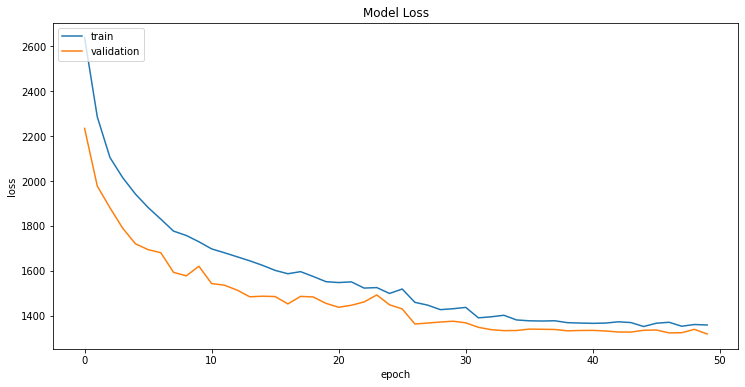

In [11]:
# Model Evaluation
hpn_result = pd.DataFrame(hpn_fit.history)

plt.figure(figsize=(27,6))
# Plot Train and Validation Loss
plt.subplot(121)
plt.plot(hpn_result['loss'])
plt.plot(hpn_result['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Model Loss')
plt.legend(['train', 'validation'], loc='upper left')


## Load Model

In [11]:
# SavedModel Path
model_path = pathlib.Path('Training/model')
model_path.mkdir(parents=True, exist_ok=True)
load_model_name = 'HPN_EfficientNetB0_300wlp_v1'
model_file = os.path.join(model_path, load_model_name)

# Load Model Architecture and Weights
hpn_go.compile(loss=losses, optimizer=optmz)
hpn_go.compute_output_shape(input_shape=(None, *img_shape))
hpn_go.load_weights(weight_file)


## Prediction Function

In [17]:
# Function to predict euler bins
def hpn_predict_bins(loaded_model, input_tensor):
    pred_bins = loaded_model(input_tensor)
    return pred_bins['Pitch'], pred_bins['Yaw'], pred_bins['Roll']

# Function to calculate predict angle
@tf.function
def derive_eur(pred_bins, bin_index, bin_degree, angle_range):
    pred_eur = tf.reduce_sum(tf.nn.softmax(pred_bins) * bin_index, axis=1) * bin_degree - angle_range
    return pred_eur
    
# Function to calculate total square error (TSE)
@tf.function
def cal_TSE(y_true, y_pred):
    TSE = tf.reduce_sum((y_true - y_pred) ** 2)
    return TSE

# Function to calculate total absolute error (TAE)
@tf.function
def cal_TAE(y_true, y_pred):
    TAE = tf.reduce_sum(tf.math.abs(y_true - y_pred))
    return TAE


## Calculate MSE & MAE

In [19]:
# Initialization
input_width = 224
input_height = 224

count = 0
batch_count = 100

pitch_TSE = 0
yaw_TSE = 0
roll_TSE = 0

pitch_TAE = 0
yaw_TAE = 0
roll_TAE = 0

bin_index = np.array([idx for idx in range(nbins)], dtype=np.float32)
bin_degree = 2 * angle_range / nbins

num_batch = len(test_idx) // batch_count + 1
last_batch_size = len(test_idx) % batch_count

# Load and Calculate Squared Error by batch
for i in range(num_batch):
    batch_idx = np.array(test_idx[i*batch_count : min((i+1)*batch_count, len(test_idx))])
    batch_img_list = np.array(img_list)[batch_idx]
    batch_eur_list = np.array(eur_list)[batch_idx]
    
    batch_img_data = []
    batch_eur_data = []
    # Load image and euler angles
    for i in range(len(batch_idx)):
        # Load image
        img_path = batch_img_list[i]
        load_img = cv2.imread(img_path)
        img = cv2.resize(load_img, (input_width, input_height))
        # Load euler angles
        eur_path = batch_eur_list[i]
        eur_file = open(eur_path, 'r')
        eur = np.array(eur_file.readlines()[0].split(','), dtype=np.float32)[[0,2]] # Only take pitch and roll
        eur_file.close()
        # Appends
        batch_img_data.append(img)
        batch_eur_data.append(eur)
    
    batch_img_data = np.array(batch_img_data)
    batch_eur_data = np.array(batch_eur_data)
    # Bin Prediction
    pitch_bins, yaw_bins, roll_bins = hpn_predict_bins(hpn_go, batch_img_data)
    
    # Euler Prediction
    pitch_eur = derive_eur(pitch_bins, bin_index, bin_degree, angle_range)
    yaw_eur   = derive_eur(yaw_bins, bin_index, bin_degree, angle_range)
    roll_eur  = derive_eur(roll_bins, bin_index, bin_degree, angle_range)
    
    # Calculate TSE
    batch_pitch_TSE = cal_TSE(batch_eur_data[:,0], pitch_eur)
    batch_yaw_TSE   = cal_TSE(batch_eur_data[:,0], yaw_eur)
    batch_roll_TSE  = cal_TSE(batch_eur_data[:,1], roll_eur)
    
    # Calculate TAE
    batch_pitch_TAE = cal_TAE(batch_eur_data[:,0], pitch_eur)
    batch_yaw_TAE   = cal_TAE(batch_eur_data[:,0], yaw_eur)
    batch_roll_TAE  = cal_TAE(batch_eur_data[:,1], roll_eur)
    
    # Append Results
    pitch_TSE += batch_pitch_TSE
    yaw_TSE   += batch_yaw_TSE
    roll_TSE  += batch_roll_TSE
    pitch_TAE += batch_pitch_TAE
    yaw_TAE   += batch_yaw_TAE
    roll_TAE  += batch_roll_TAE
    count     += len(batch_idx)

# Calculate final Stats
pitch_MSE = pitch_TSE.numpy() / count
yaw_MSE   = yaw_TSE.numpy() / count
roll_MSE  = roll_TSE.numpy() / count
pitch_MAE = pitch_TAE.numpy() / count
yaw_MAE   = yaw_TAE.numpy() / count
roll_MAE  = roll_TAE.numpy() / count
avg_MSE   = (pitch_MSE + yaw_MSE + roll_MSE)/3
avg_MAE   = (pitch_MAE + yaw_MAE + roll_MAE)/3

print('==========================================================================')
print('Individual Euler Angle Mean Squared Error (MSE):')
print('------------------------------------------------')
print('Pitch MSE :', str(round(pitch_MSE,3)))
print('Yaw MSE   :', str(round(yaw_MSE,3)))
print('Roll MSE  :', str(round(roll_MSE,3)))
print('==========================================================================')
print('Individual Euler Angle Mean Absolute Error (MAE):')
print('------------------------------------------------')
print('Pitch MAE :', str(round(pitch_MAE,3)))
print('Yaw MAE :', str(round(yaw_MAE,3)))
print('Roll MAE  :', str(round(roll_MAE,3)))
print('==========================================================================')
print('Overall MSE & MAE:')
print('------------------------------------------------')
print('MSE :', str(round(avg_MSE,3)))
print('MAE :', str(round(avg_MAE,3)))

Individual Euler Angle Mean Squared Error (MSE):
------------------------------------------------
Pitch MSE : 44.096
Yaw MSE   : 1957.015
Roll MSE  : 114.556
Individual Euler Angle Mean Absolute Error (MAE):
------------------------------------------------
Pitch MAE : 4.07
Yaw MAE : 36.117
Roll MAE  : 7.243
Overall MSE & MAE:
------------------------------------------------
MSE : 705.222
MAE : 15.81
